In [21]:
np.mod(10, 3)

1

In [93]:
# Import the necessary libraries
import warnings
import numpy as np
from scipy.stats import truncnorm
from random import uniform, sample

# Ignore irrelevant lower outputs
warnings.filterwarnings("ignore")

def surgebinder(n_curves,
                x_interval,
                y_interval,
                n_measure,
                direction_maximum,
                convergence_point,
                log_scale = False,
                trunc_norm = False,
                change_range = None,
                start_force = None):
    ###
    
    print("Generating random curves ...\n")
    # If no change range is given, set limits to 10% and 90%
    if change_range == None:
        change_range = [0.1, 0.9]
    # Calculate both the step size and measurement locations
    difference = np.diff([x_interval[0], x_interval[1]])
    step_size = np.divide(difference, n_measure - 1)
    steps = [x_interval[0] + np.multiply(i, step_size)
             for i in range(0, n_measure)]
    # Initialize an empty list for storing the curves later
    curves = []
    # Remember the initially user-requested number of curves
    orig_request = n_curves
    n_curves = int(np.multiply(n_curves, 2))
    multiplicator = np.maximum(1, np.multiply(2, direction_maximum))
    n_curves = int(np.multiply(n_curves, multiplicator))
    if n_curves >= 10:
        # Set 10%-based printout milestones for progress updates
        iter_range = np.array_split(np.arange(0, n_curves), 10)
        print_points = [entry[-1] for entry in iter_range]
        percentage = 0
    else:
        progress_update = 0
    # Set an indicator for a requested flat state at the start
    if start_force == None:
        flat_state = False
    else:
        flat_state = True
        # If for log-scale, recalculate the flat state ending
        if log_scale == True:
            log_steps, log_step_size = logarithmic(x_interval = x_interval,
                                                    n_measure = n_measure)
            log_cut = np.min(np.where(np.asarray(log_steps) > start_force)[0])
            start_force = steps[log_cut]    
        flat_value = start_force
    # Loop over the required total number of separate curves
    for curve in range(0, n_curves):
        # Reset the start force if a flat state is requested
        if flat_state == True:
            start_force = flat_value
        # Generate the random force direction change points
        allowed = range(0, np.random.randint(0, direction_maximum + 1))
        if start_force == None:
            lower_range = int(np.multiply(len(steps), change_range[0]))
        else:
            flat_change = int(np.floor(np.divide(start_force, step_size)))
            lower_range = int(np.multiply(len(steps), change_range[0]) + flat_change)
            #lower_range = int(np.ceil(start_force))
        higher_range = int(np.multiply(len(steps), change_range[1]))
        sample_range = range(lower_range, higher_range)
        sample_number = np.random.randint(0, direction_maximum + 1)
        change_points = np.sort(sample(sample_range, sample_number))
        if start_force != None:
            # Adapt the change points to allow the flat start     
            if not list(change_points):
                change_points = [flat_change]
            else:
                change_points = np.hstack((flat_change, change_points))
        # Generate a random initial direction for the force
        direction = np.random.choice([-1, 1])
        # Set the particle's velocity to an arbitrary value
        velocity = 1.0
        # Set the angle to zero for a left-side convergence
        launch_angle = 0.0
        # Get the maximum force to stay within the intervals
        rest_time = np.divide(x_interval[1], velocity  )
        max_range = y_interval[np.maximum(0, direction)] - convergence_point[1]
        abs_max = np.multiply(np.negative(direction), (max_range))
        spread = np.multiply(velocity, np.sin(launch_angle)) - abs_max
        force_max = np.divide(np.multiply(2, spread), np.square(rest_time))
        # Randomly sample the force depending on preferences
        if trunc_norm == True:
            distribution = truncnorm.rvs(a = -2, b = 2)
            force = np.multiply(np.abs(distribution), np.divide(force_max, 2))
        else:
            force = uniform(0, force_max)
        # Set the convergence point as the first start point
        start_point = convergence_point
        # Initialize a curve path, start distance and counter
        curve_path = [convergence_point]
        horizontal_start = [0.0]
        counter = 0
        # Initialize the beginning as the last visited point
        last_point = convergence_point
        # Loop over change points to calculate partial curves
        for part in range(0, len(change_points) + 1):
            # Set the steps depending on the process' status
            if not list(change_points):
                partial_steps = steps[counter:len(steps)]
            else:
                partial_steps = steps[counter:change_points[0] + 1]
                counter = change_points[0]
                change_points = change_points[1:len(change_points)]
                # Sample a random force for the partial curve
                scale_factor = np.divide(len(steps), len(partial_steps))
                force_max = np.multiply(force_max, scale_factor)
                if start_force == None:
                    if trunc_norm == True:
                        distr = truncnorm.rvs(a = -2, b = 2)
                        force = np.multiply(np.abs(distr), np.divide(force_max, 2))
                    else:
                        force = uniform(0, force_max)
                else:
                    force = 0.0
                    start_force = None
            #print(len(partial_steps))
            # Calculate the trajectory for the partial curve
            output = trajectory(force = force,
                                velocity = velocity,
                                direction = direction,
                                step_size = step_size,
                                start_point = start_point,
                                launch_angle = launch_angle,
                                partial_steps = partial_steps,
                                horizontal_start = horizontal_start)
            # Assign the values from the trajectory function
            partial_path, last_point, launch_angle, velocity = output[0:4]
            # Update parameters for the next loop iteration
            start_point = last_point
            direction = -direction
            force = np.negative(force)
            horizontal_start = [convergence_point[0]]
             # Get the maximum force to stay within the intervals
            rest_time = np.divide(x_interval[1] - last_point[0], velocity)
            max_range = y_interval[np.maximum(0, direction)] - last_point[1]
            abs_max = np.multiply(np.negative(direction), (max_range))
            spread = np.multiply(velocity, np.sin(launch_angle)) - abs_max
            force_max = np.divide(np.multiply(2, spread), np.square(rest_time))
            # Randomly sample the force depending on preferences
            if trunc_norm == True:
                distr = truncnorm.rvs(a = -2, b = 2)
                force = np.multiply(np.abs(distr), np.divide(force_max, 2))
            else:
                force = uniform(0, force_max)
            # Convert the partial path into a congestible format
            partial_path = np.asarray(partial_path)
            if not partial_path.ndim < 2:
                partial_path = partial_path.reshape(partial_path.shape[0],
                                                    partial_path.shape[1])
                curve_path = np.vstack((curve_path, partial_path))
        # Append the computed curve to the complete set of curves
        append_point = np.asarray(last_point).T
        append_path = curve_path[1:len(curve_path), :]
        curve_path = np.vstack((append_path, append_point))
        curves.append(curve_path)
        # Print progress updates to inform about remaining time
        if n_curves >= 10:
            if curve == print_points[0]:
                percentage = percentage + 10
                print("%d %%" % percentage)
                print_points = print_points[1:len(iter_range)]
        else:
            progress_update = progress_update + 1
            if np.mod(progress_update, 2) == 0:
                print("%d curves generated" % np.divide(progress_update, 2))
    # Transform to log-scale measurements if required by the user
    if log_scale == True:
        steps, step_size = logarithmic(x_interval = x_interval,
                                       n_measure = n_measure)
        # Save the log-scale measurement points into the curves
        for i in range(0, len(curves)):
            #print(len(steps))
            #print(len(curves[i]))
            #print()
            for j in range(0, len(curves[i])):
                curves[i][j][0] = steps[j]
    # Remove curves with trajectories beyond the allowed range
    remove = []
    for i in range(0, len(curves)):
        if (any(curves[i][:, 1] < y_interval[0])
            or any(curves[i][:, 1] > y_interval[1])):
            remove.append(i)
    for index in sorted(remove, reverse = True):
        del curves[index]
    # Cut the dataset to the user-requested number of curves
    curves = curves[0:orig_request]
    print("\nComplete, returning your curves!")
    # Return the list of random curves as the function output
    return curves


def logarithmic(x_interval,
                n_measure):
    log_interval = np.log10(x_interval)
    difference = np.diff([log_interval[0], log_interval[1]])
    step_size = np.divide(difference, n_measure - 1)
    steps = [np.power(10, log_interval[0] + np.multiply(i, step_size))
                 for i in range(0, n_measure)]
    return steps, step_size


def trajectory(force,
               velocity,
               direction,
               step_size,
               start_point,
               launch_angle,
               partial_steps,
               horizontal_start):
    ###

    # Initialize the horizontal displacement with the input
    horizontal_displacement = [horizontal_start]
    # Calculate the first horizontal and vertical velocities
    horizontal_velocity = np.multiply(velocity, np.cos(launch_angle))
    vertical_velocity = np.multiply(velocity, np.sin(launch_angle))
    # Save the initial velocity for consecutive calculations
    start_velocity = velocity
    # Initialize a list for storing the measurement points
    points = [start_point]
    # Loop over the number of steps minus the initial step
    for i in range(1, len(partial_steps)):
        # Get the horizontal distance, displacement and time
        distance = partial_steps[i]
        horizontal_displacement = horizontal_displacement + step_size
        time = np.divide(horizontal_displacement, horizontal_velocity)
        # Calculate the vertical velocity and displacement
        interim = np.multiply(start_velocity, np.sin(launch_angle))
        vertical_velocity = interim - np.multiply(force, time)
        velocity_part = np.multiply(start_velocity,
                                    np.multiply(np.sin(launch_angle), time))
        force_part = np.multiply(0.5, np.multiply(force, np.square(time)))
        vertical_displacement = np.negative(velocity_part - force_part)
        # Calculate the total velocity at the given point
        velocity = np.sqrt(np.square(horizontal_velocity)
                           + np.square(vertical_velocity))
        # Append the current measurement point to the list
        direction_displacement = np.multiply(direction, vertical_displacement)
        points.append([distance, start_point[1] + direction_displacement])
    # Calculate both the final velocity and impact angle
    final_velocity = np.sqrt(np.square(horizontal_velocity)
                             + np.square(vertical_velocity))
    impact_angle = np.arctan(np.divide(np.negative(vertical_velocity),
                             horizontal_velocity))
    # Separate the last measurement point from the points
    last_point = points[-1]
    points = points[0:-1]
    # Return the points, last point, angle and velocity
    return points, last_point, impact_angle, velocity


In [36]:
# Generate 1000 curves with the parameters requested

import time

start_time = time.clock()

curves = surgebinder(n_curves = 1000,
                     x_interval = [0.001, 10],
                     y_interval = [0.0, 5.0],
                     n_measure = 600,
                     direction_maximum = 1,
                     convergence_point = [0.001, 1.0],
                     log_scale = True,
                     trunc_norm = False,
                     start_force = 0.01)

stop_time = time.clock()
print('\nRuntime: %f seconds' % (stop_time - start_time))

Generating random curves ...

10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100 %

Complete, returning your curves!

Runtime: 28.992693 seconds


In [38]:
# Load the necessary packages
import pickle

# Save the assignments as a PKL file
with open('1000_random_curves.pkl', 'wb') as f:
    pickle.dump(curves, f)

In [39]:
# Load the assignments from a PKL file
with open('1000_random_curves.pkl', 'rb') as f:
    load_curves = pickle.load(f)

(0.001, 10)

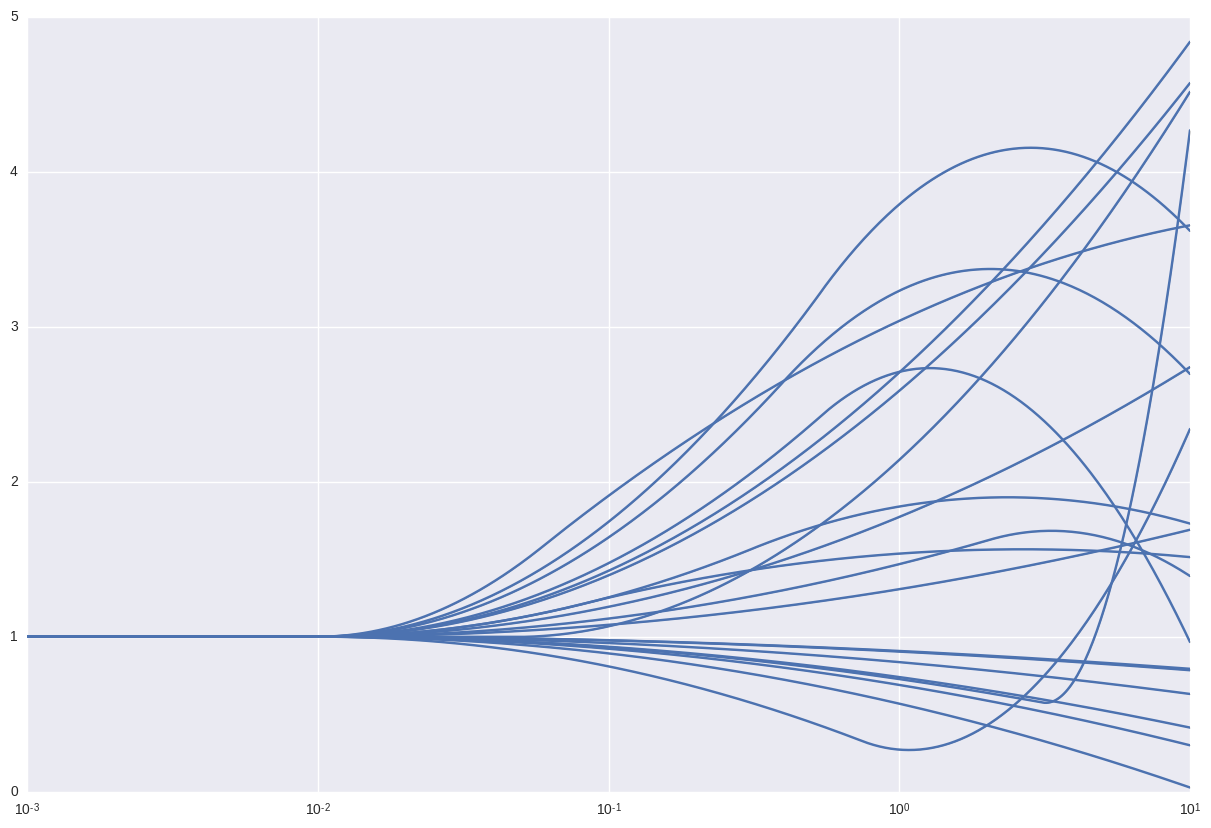

In [42]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

x_interval = [0.001, 10]
y_interval = [0.0, 5.0]

f, ax = plt.subplots(figsize=(15, 10))
ax.set(xscale="log")

for i in range(0, 20):
    sns.tsplot(np.asarray(load_curves[i])[:, 1], np.asarray(load_curves[i])[:, 0], ax = ax)

plt.ylim(y_interval[0], y_interval[1])
plt.xlim(x_interval[0], x_interval[1])

Generating random curves ...

10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100 %

Complete, returning your curves!


(0.001, 10)

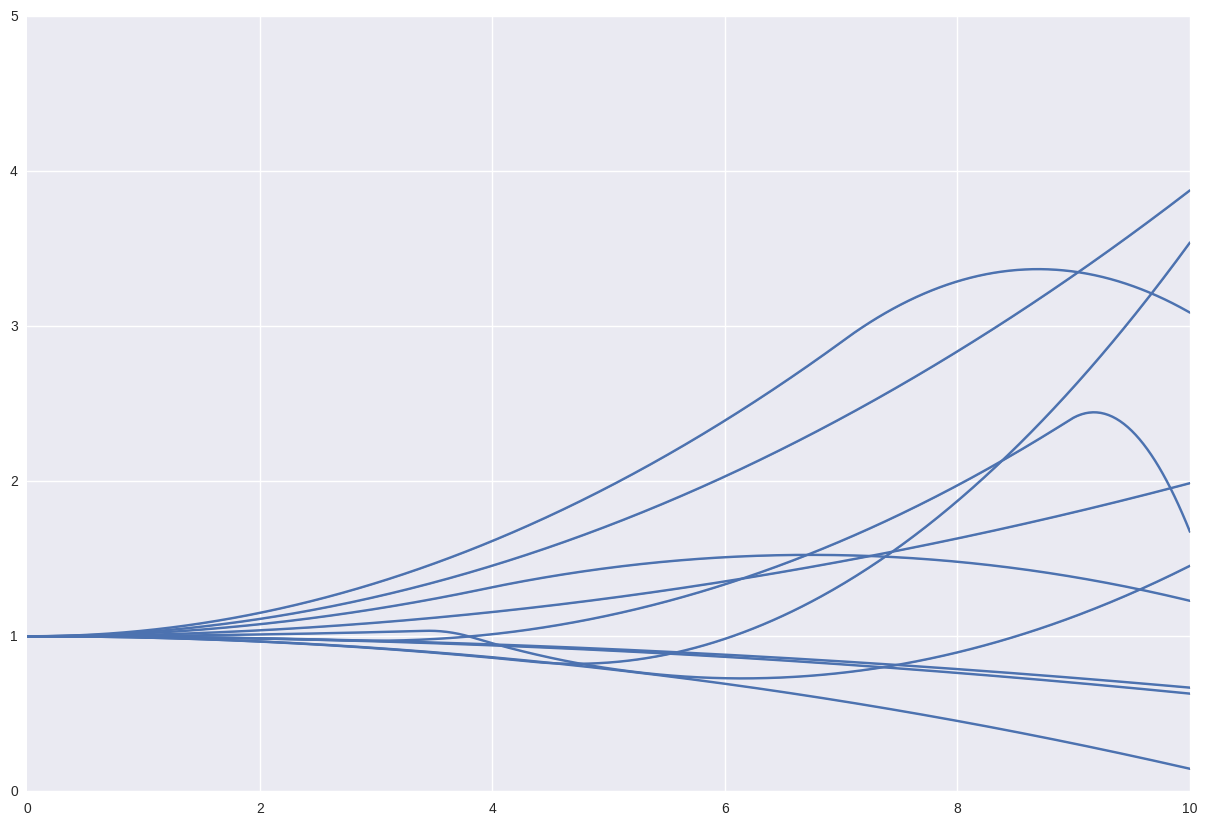

In [95]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

x_interval = [0.001, 10]
y_interval = [0.0, 5.0]

curves = surgebinder(n_curves = 10,
                     x_interval = [0.001, 10],
                     y_interval = [0.0, 5.0],
                     n_measure = 600,
                     direction_maximum = 2,
                     convergence_point = [0.001, 1.0],
                     log_scale = False,
                     trunc_norm = False,
                     start_force = 0.05)

f, ax = plt.subplots(figsize=(15, 10))
#ax.set(xscale="log")

for i in range(0, len(curves)):
    sns.tsplot(np.asarray(curves[i])[:, 1], np.asarray(curves[i])[:, 0], ax = ax)

plt.ylim(y_interval[0], y_interval[1])
plt.xlim(x_interval[0], x_interval[1])

(0.01, 10)

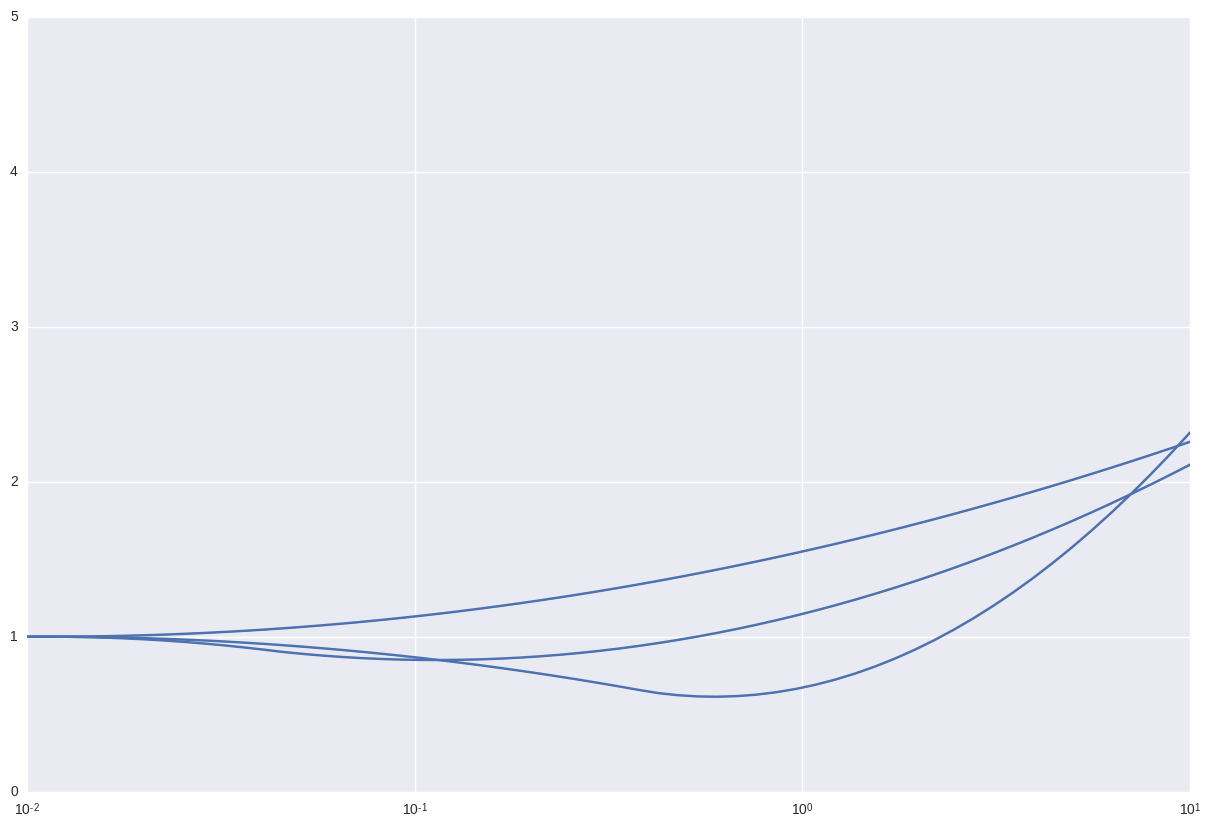

In [472]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

x_interval = [0.01, 10]
y_interval = [0.0, 5.0]

curves = surgebinder(n_curves = 3,
                     x_interval = [0.01, 10],
                     y_interval = [0.0, 5.0],
                     n_measure = 60,
                     direction_maximum = 1,
                     convergence_point = [0.01, 1.0],
                     log_scale = True,
                     trunc_norm = True,
                     start_force = 0.01)

#plt.figure(figsize = (15, 10))

f, ax = plt.subplots(figsize=(15, 10))
ax.set(xscale="log")

for i in range(0, len(curves)):
    sns.tsplot(np.asarray(curves[i])[:, 1], np.asarray(curves[i])[:, 0], ax = ax)

plt.ylim(y_interval[0], y_interval[1])
plt.xlim(x_interval[0], x_interval[1])

In [473]:
curves

[array([[  0.01      ,   1.        ],
        [  0.0112421 ,   1.        ],
        [  0.01263848,   0.99923124],
        [  0.01420831,   0.99709405],
        [  0.01597312,   0.99358605],
        [  0.01795714,   0.98870723],
        [  0.0201876 ,   0.98245759],
        [  0.02269511,   0.97483713],
        [  0.02551407,   0.96584585],
        [  0.02868317,   0.95548376],
        [  0.03224591,   0.94375084],
        [  0.03625117,   0.93064711],
        [  0.04075393,   0.91617256],
        [  0.04581598,   0.90108306],
        [  0.05150678,   0.88860805],
        [  0.05790444,   0.87785519],
        [  0.06509675,   0.86882448],
        [  0.07318242,   0.86151593],
        [  0.08227241,   0.85592954],
        [  0.09249147,   0.85206531],
        [  0.10397984,   0.84992323],
        [  0.11689518,   0.8495033 ],
        [  0.13141474,   0.85080554],
        [  0.14773777,   0.85382992],
        [  0.16608828,   0.85857647],
        [  0.18671811,   0.86504517],
        [  0

In [45]:
start_force = 2.5
change_points = np.hstack((int(np.ceil(start_force)), change_points))
change_points

array([3, 3, 3, 3, 3, 3, 1, 8])

In [466]:
# Import the necessary libraries
import warnings
import numpy as np
from scipy.stats import truncnorm
from scipy.ndimage.interpolation import shift
from random import uniform, sample

# Ignore irrelevant lower outputs
warnings.filterwarnings("ignore")

def surgebinder(n_curves,
                x_interval,
                y_interval,
                n_measure,
                direction_maximum,
                convergence_point,
                log_scale = False,
                trunc_norm = False,
                change_range = None,
                start_force = None):
    ###

    # If no change range is given, set limits to 10% and 90%
    if change_range == None:
        change_range = [0.1, 0.9]
    # Calculate both the step size and measurement locations
    difference = np.diff([x_interval[0], x_interval[1]])
    step_size = np.divide(difference, n_measure - 1)
    steps = [x_interval[0] + np.multiply(i, step_size)
             for i in range(0, n_measure)]
    # Initialize an empty list for storing the curves later
    curves = []
    # Remember the initially user-requested number of curves
    orig_request = n_curves
    n_curves = int(np.multiply(n_curves, 2))
    # Loop over the required total number of separate curves
    for curve in range(0, n_curves):
        # Generate the random force direction change points
        allowed = range(0, np.random.randint(0, direction_maximum + 1))
        lower_range = int(np.multiply(len(steps), change_range[0]))
        higher_range = int(np.multiply(len(steps), change_range[1]))
        sample_range = range(lower_range, higher_range)
        sample_number = np.random.randint(0, direction_maximum + 1)
        change_points = np.sort(sample(sample_range, sample_number))
        # Generate a random initial direction for the force
        direction = np.random.choice([-1, 1])
        # Set the particle's velocity to an arbitrary value
        velocity = 1.0
        # Set the angle to zero for a left-side convergence
        launch_angle = 0.0
        # Get the maximum force to stay within the intervals
        rest_time = np.divide(x_interval[1], velocity  )
        max_range = y_interval[np.maximum(0, direction)] - convergence_point[1]
        abs_max = np.multiply(np.negative(direction), (max_range))
        spread = np.multiply(velocity, np.sin(launch_angle)) - abs_max
        force_max = np.divide(np.multiply(2, spread), np.square(rest_time))
        # Randomly sample the force depending on preferences
        if trunc_norm == True:
            distribution = truncnorm.rvs(a = -2, b = 2)
            force = np.multiply(np.abs(distribution), np.divide(force_max, 2))
        else:
            force = uniform(0, force_max)
        # Set the convergence point as the first start point
        start_point = convergence_point
        # Initialize a curve path, start distance and counter
        curve_path = [0.0, 0.0]
        horizontal_start = [0.0]
        counter = 0
        # Initialize the beginning as the last visited point
        last_point = convergence_point
        # Loop over change points to calculate partial curves
        for part in range(0, len(change_points) + 1):
            # Set the steps depending on the process' status
            if not list(change_points):
                partial_steps = steps[counter:len(steps)]
            else:
                partial_steps = steps[counter:change_points[0] + 1]
                counter = change_points[0]
                change_points = change_points[1:len(change_points)]
                # Sample a random force for the partial curve
                scale_factor = np.divide(len(steps), len(partial_steps))
                force_max = np.multiply(force_max, scale_factor)
                if trunc_norm == True:
                    distr = truncnorm.rvs(a = -2, b = 2)
                    force = np.multiply(np.abs(distr), np.divide(force_max, 2))
                else:
                    force = uniform(0, force_max)
            # Calculate the trajectory for the partial curve
            output = trajectory(force = force,
                                velocity = velocity,
                                direction = direction,
                                step_size = step_size,
                                start_point = start_point,
                                launch_angle = launch_angle,
                                partial_steps = partial_steps,
                                horizontal_start = horizontal_start)
            # Assign the values from the trajectory function
            partial_path, last_point, launch_angle, velocity = output[0:4]
            # Update parameters for the next loop iteration
            start_point = last_point
            direction = -direction
            force = np.negative(force)
            horizontal_start = [convergence_point[0]]
             # Get the maximum force to stay within the intervals

            rest_time = np.divide(x_interval[1] - last_point[0], velocity)
            max_range = y_interval[np.maximum(0, direction)] - last_point[1]
            abs_max = np.multiply(np.negative(direction), (max_range))
            spread = np.multiply(velocity, np.sin(launch_angle)) - abs_max
            force_max = np.divide(np.multiply(2, spread), np.square(rest_time))
            # Randomly sample the force depending on preferences
            if trunc_norm == True:
                distr = truncnorm.rvs(a = -2, b = 2)
                force = np.multiply(np.abs(distr), np.divide(force_max, 2))
            else:
                force = uniform(0, force_max)
            # Convert the partial path into a congestible format
            partial_path = np.asarray(partial_path)
            if not partial_path.ndim < 2:
                partial_path = partial_path.reshape(partial_path.shape[0],
                                                    partial_path.shape[1])
                curve_path = np.vstack((curve_path, partial_path))
        # Append the computed curve to the complete set of curves
        append_point = np.asarray(last_point).T
        append_path = curve_path[1:len(curve_path), :]
        curve_path = np.vstack((append_path, append_point))
        curves.append(curve_path)
    # Transform to log-scale measurements if required by the user
    if log_scale == True:
        steps, step_size = logarithmic(x_interval = x_interval,
                                       n_measure = n_measure)
        # Save the log-scale measurement points into the curves
        for i in range(0, len(curves)):
            for j in range(0, len(curves[i])):
                curves[i][j][0] = steps[j]
    # Remove curves with trajectories beyond the allowed range
    remove = []
    for i in range(0, len(curves)):
        if (any(curves[i][:, 1] < y_interval[0])
            or any(curves[i][:, 1] > y_interval[1])):
            remove.append(i)
    for index in sorted(remove, reverse = True):
        del curves[index]
    # Cut the dataset to the user-requested number of curves
    curves = curves[0:orig_request]
    # If a flate beginning is required, transform the curves
    if start_force != None:
        for i in range(0, len(curves)):
            cut_ratio = np.divide(start_force, step_size)
            cut_point = np.min(np.where(curves[i][:, 0] > cut_ratio))
            cut_curve = curves[i][0:(len(curves[i]) - cut_point), 1].copy()
            curves[i][0:cut_point, 1] = convergence_point[1]
            cut_counter = 0
            for j in range(cut_point, len(curves[i])):
                curves[i][j, 1] = cut_curve[cut_counter]
                cut_counter = cut_counter + 1
    # Return the list of random curves as the function output
    return curves

def logarithmic(x_interval,
                n_measure):
    log_interval = np.log10(x_interval)
    difference = np.diff([log_interval[0], log_interval[1]])
    step_size = np.divide(difference, n_measure - 1)
    steps = [np.power(10, log_interval[0] + np.multiply(i, step_size))
                 for i in range(0, n_measure)]
    return steps, step_size

def trajectory(force,
               velocity,
               direction,
               step_size,
               start_point,
               launch_angle,
               partial_steps,
               horizontal_start):
    ###

    # Initialize the horizontal displacement with the input
    horizontal_displacement = [horizontal_start]
    # Calculate the first horizontal and vertical velocities
    horizontal_velocity = np.multiply(velocity, np.cos(launch_angle))
    vertical_velocity = np.multiply(velocity, np.sin(launch_angle))
    # Save the initial velocity for consecutive calculations
    start_velocity = velocity
    # Initialize a list for storing the measurement points
    points = [start_point]
    # Loop over the number of steps minus the initial step
    for i in range(1, len(partial_steps)):
        # Get the horizontal distance, displacement and time
        distance = partial_steps[i]
        horizontal_displacement = horizontal_displacement + step_size
        time = np.divide(horizontal_displacement, horizontal_velocity)
        # Calculate the vertical velocity and displacement
        interim = np.multiply(start_velocity, np.sin(launch_angle))
        vertical_velocity = interim - np.multiply(force, time)
        velocity_part = np.multiply(start_velocity,
                                    np.multiply(np.sin(launch_angle), time))
        force_part = np.multiply(0.5, np.multiply(force, np.square(time)))
        vertical_displacement = np.negative(velocity_part - force_part)
        # Calculate the total velocity at the given point
        velocity = np.sqrt(np.square(horizontal_velocity)
                           + np.square(vertical_velocity))
        # Append the current measurement point to the list
        direction_displacement = np.multiply(direction, vertical_displacement)
        points.append([distance, start_point[1] + direction_displacement])
    # Calculate both the final velocity and impact angle
    final_velocity = np.sqrt(np.square(horizontal_velocity)
                             + np.square(vertical_velocity))
    impact_angle = np.arctan(np.divide(np.negative(vertical_velocity),
                             horizontal_velocity))
    # Separate the last measurement point from the points
    last_point = points[-1]
    points = points[0:-1]
    # Return the points, last point, angle and velocity
    return points, last_point, impact_angle, velocity


(0.001, 10)

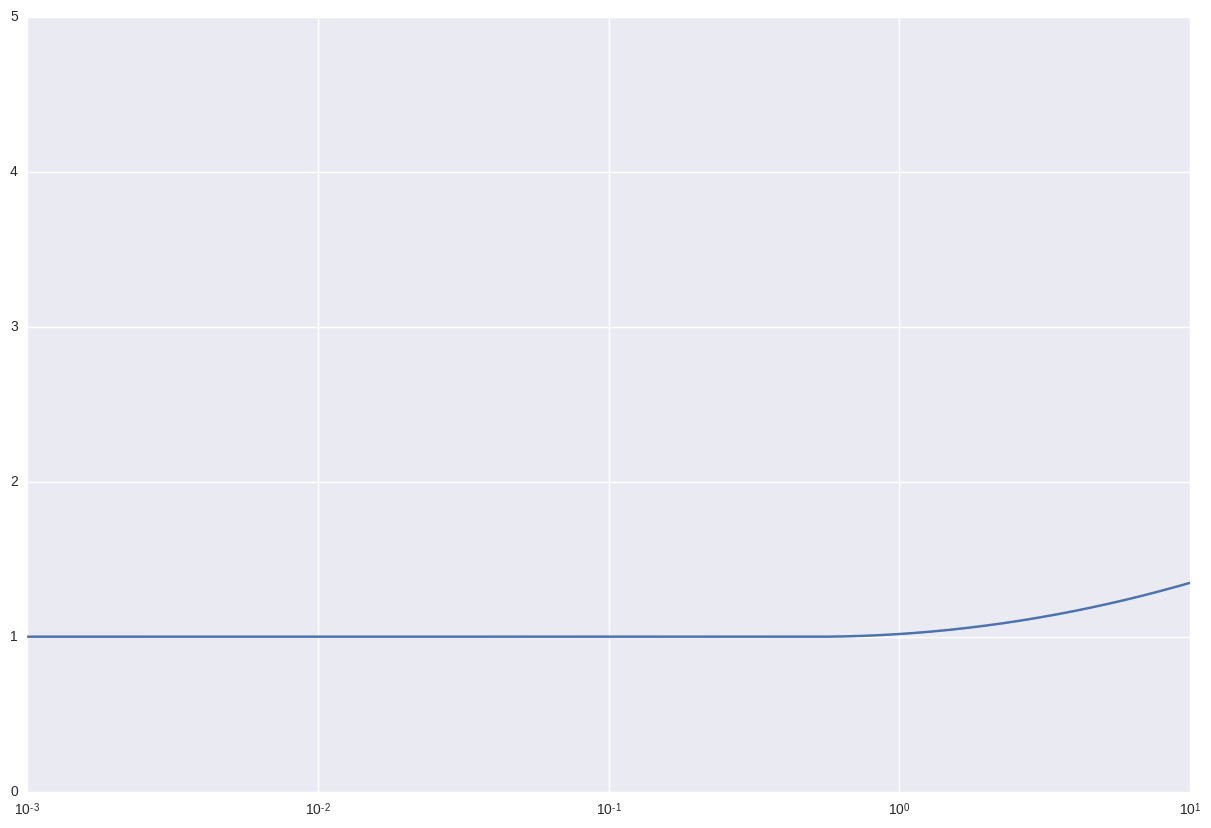

In [468]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

x_interval = [0.001, 10]
y_interval = [0.0, 5.0]

curves = surgebinder(n_curves = 1,
                     x_interval = [0.001, 10],
                     y_interval = [0.0, 5.0],
                     n_measure = 200,
                     direction_maximum = 1,
                     convergence_point = [0.001, 1.0],
                     log_scale = True,
                     trunc_norm = False,
                     start_force = 0.01)

#plt.figure(figsize = (15, 10))

f, ax = plt.subplots(figsize=(15, 10))
ax.set(xscale="log")

for i in range(0, len(curves)):
    sns.tsplot(np.asarray(curves[i])[:, 1], np.asarray(curves[i])[:, 0], ax = ax)

plt.ylim(y_interval[0], y_interval[1])
plt.xlim(x_interval[0], x_interval[1])

In [455]:
curves

[array([[  1.00000000e-03,   1.00000000e+00],
        [  1.04737090e-03,   1.00000000e+00],
        [  1.09698580e-03,   1.00000000e+00],
        [  1.14895100e-03,   1.00000000e+00],
        [  1.20337784e-03,   1.00000000e+00],
        [  1.26038293e-03,   1.00000000e+00],
        [  1.32008840e-03,   1.00000000e+00],
        [  1.38262217e-03,   1.00000000e+00],
        [  1.44811823e-03,   1.00000000e+00],
        [  1.51671689e-03,   1.00000000e+00],
        [  1.58856513e-03,   1.00000000e+00],
        [  1.66381689e-03,   1.00000000e+00],
        [  1.74263339e-03,   1.00000000e+00],
        [  1.82518349e-03,   1.00000000e+00],
        [  1.91164408e-03,   1.00000000e+00],
        [  2.00220037e-03,   1.00000000e+00],
        [  2.09704640e-03,   1.00000000e+00],
        [  2.19638537e-03,   1.00000000e+00],
        [  2.30043012e-03,   1.00000000e+00],
        [  2.40940356e-03,   1.00000000e+00],
        [  2.52353917e-03,   1.00000000e+00],
        [  2.64308149e-03,   1.000